In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [2]:

data = pd.read_csv("test_assignment_sim.csv")

sites_datas = []
for i in range(49):
    slice = data.iloc[:,[0,1,2,3]].copy()
    slice['thickness'] = data.iloc[:,i+4]
    slice['SITE'] = i # in lgb, catagory should be a int
    sites_datas.append(slice)

site_thickness = sites_datas[0]
for j in range(1,49):
    site_thickness = pd.concat([site_thickness,sites_datas[j]])

clist = list(site_thickness.columns)
clist.append(clist.pop(4))
site_thickness = site_thickness[clist]
site_thickness.reset_index(drop=True)
site_thickness['TOOL'] = site_thickness['TOOL'].astype('category')
site_thickness['SITE'] = site_thickness['SITE'].astype('category')

site_thickness.head(20)


,FLOWFACTOR,SPACING,DEP TIME,TOOL,SITE,thickness
0,0.916,0.344,69.289,1,0,1601.802686
1,0.916,0.344,69.289,2,0,1516.411140
2,0.916,0.344,69.289,3,0,1478.098433
3,0.916,0.344,69.289,4,0,1550.290615
4,0.957,0.348,70.253,1,0,1544.883218
5,0.957,0.348,70.253,2,0,1489.344728
6,0.957,0.348,70.253,3,0,1493.257169
7,0.957,0.348,70.253,4,0,1532.502760
8,0.958,0.346,67.731,1,0,1510.842000
9,0.958,0.346,67.731,2,0,1459.394993


In [3]:
site_thickness.info()
site_thickness.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   FLOWFACTOR  24500 non-null  float64 
 1   SPACING     24500 non-null  float64 
 2   DEP TIME    24500 non-null  float64 
 3   TOOL        24500 non-null  category
 4   SITE        24500 non-null  category
 5   thickness   24500 non-null  float64 
dtypes: category(2), float64(4)
memory usage: 1006.5 KB


,FLOWFACTOR,SPACING,DEP TIME,thickness
count,24500.000000,24500.00000,24500.000000,24500.000000
mean,0.946520,0.34952,70.408920,1503.164632
std,0.024437,0.00470,1.809077,60.713176
min,0.887000,0.33400,66.373000,1314.987107
25%,0.929000,0.34700,69.264000,1462.423144
50%,0.948000,0.35000,70.443000,1506.993545
75%,0.962000,0.35200,71.411000,1544.670201
max,1.003000,0.36300,76.008000,1674.742137


In [4]:

# training data preparation 
dftrain,dftest = train_test_split(site_thickness,test_size=0.1)

categorical_features = ['TOOL','SITE']
lgb_train = lgb.Dataset(dftrain.drop(['thickness'],axis = 1),label=dftrain['thickness'],
                        categorical_feature = categorical_features,free_raw_data=False)

lgb_valid = lgb.Dataset(dftest.drop(['thickness'],axis = 1),label=dftest['thickness'],
                        categorical_feature = categorical_features,
                        reference=lgb_train,free_raw_data=False)


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032995 seconds.
You can set `force_col_wise=true` to remove the overhead.


/opt/anaconda3/envs/tf/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


The rmse of prediction is: 4.564868601213125


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

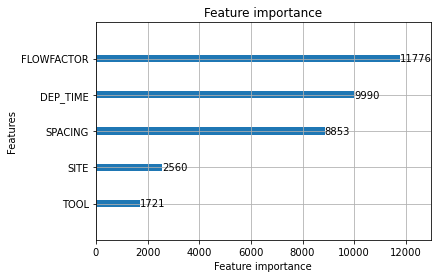

In [5]:

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 350,
    'learning_rate': 0.05,
    'bagging_fraction': 0.9,
    'bagging_freq': 2,
    'verbose': 0,
    'max_depth':25

}

gbm = lgb.train(params,lgb_train)

y_pred = gbm.predict(dftest.drop(['thickness'],axis = 1), num_iteration=gbm.best_iteration) 
print('The rmse of prediction is:', mean_squared_error(dftest['thickness'], y_pred) ** 0.5)
lgb.plot_importance(gbm)